# Load data


In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("files/train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("files/test.csv", encoding="ISO-8859-1")
descriptions = pd.read_csv("files/product_descriptions.csv", encoding="ISO-8859-1")

df = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df = pd.merge(df, descriptions, how='left', on='product_uid')

# Feature extraction

In [8]:
def common_words(str1, str2):
    word_count = 0
    for word in str1.split():
        if word in str2:
            word_count += 1
    return word_count

df["word_in_title"]         = df.apply(lambda row: common_words(row["search_term"], row["product_title"]), axis=1)
df["word_in_description"]   = df.apply(lambda row: common_words(row["search_term"], row["product_description"]), axis=1)
df["query_in_title"]        = df.apply(lambda row: 1 if row["search_term"] in row["product_title"] else 0, axis=1)
df["query_in_description"]  = df.apply(lambda row: 1 if row["search_term"] in row["product_description"] else 0, axis=1)
df['length_of_query']       = df['search_term'].map(lambda x:len(x.split())).astype(np.int64)

num_train = df_train.shape[0]

train = df.iloc[:num_train]
test = df.iloc[num_train:]

predictors = ["word_in_description", "word_in_title", "query_in_title", "query_in_description", "length_of_query"]

X_train = train[predictors]
Y_train = train["relevance"]

# Feature Selection

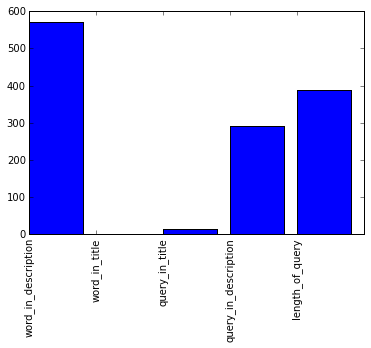

In [7]:
%matplotlib inline

from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt

# Perform feature selection
selector = SelectKBest(f_regression, k=2)
selector.fit(X_train, Y_train)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = selector.scores_

# Plot the scores.
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Fit data

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsRegressor(n_neighbors=5)
scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring='mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

#TODO: cross validate to find right algorithm. Run grid search to pick optimal parameters

0.576205015838
0.521125010507


#Predict


In [ ]:
predictions = knn.predict(test[predictors].values)

submission = pd.DataFrame({
        "id": test["id"],
        "relevance": predictions
    }).to_csv('submission.csv',index=False)